## Manjiri Pendharkar - 45933219

Github url - https://github.com/MQCOMP2200-S2-2020/portfolio-2020-manjiri2077

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

Your goal in this portfolio is to take this data and build predictive models to classify the books into one of the five target genres.  You will need to extract suitable features from the texts and select suitable models to classify them. You should build and evaluate at least TWO models and compare the prediction results.

You should report on each stage of your experiment as you work with the data.


## Data Preparation

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [2]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [3]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape


(8954, 5)

In [4]:
genre_books.head()

,title,author,date,summary,genre
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy


In [5]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()


,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


## Label encoding


In [6]:
le =LabelEncoder()
le.fit(list(genre_books['genre'].values))

LabelEncoder()

In [7]:
# creating a new colum genre_no to have encoded labels
genre_books['genre_no']= le.transform(list(genre_books['genre']))
genre_books.head()

,title,author,date,summary,genre,genre_no
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,0
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,3
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,3
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,1
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,1


In [8]:
target_names =list(le.inverse_transform([0,1,2,3,4]))
print(target_names)

["Children's literature", 'Fantasy', 'Mystery', 'Novel', 'Science Fiction']


## TfidfVectorization
To convert a collection of raw documents of book summaries to a matrix of TF-IDF features by building a vocabulary that only consider the top  5000 max_features (5000 most frequent words from summary)

In [9]:
vectorizer = TfidfVectorizer(max_features = 5000)
X = vectorizer.fit_transform(genre_books.summary).toarray()
print(X.shape)

(8954, 5000)


## Data splitting into training and testing

In [10]:
X_train, X_test, y_train, y_test =train_test_split(X,genre_books['genre_no'], test_size=0.2, random_state=142)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7163, 5000)
(7163,)
(1791, 5000)
(1791,)


## Model training

## Modelling using Logistic Regression

In [11]:
# Build the model
lr= LogisticRegression()

# Train the model with the training data
lr.fit(X_train,y_train)

C:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [12]:
# prediction on testing data
y_test_pred = lr.predict(X_test)

In [13]:
print(classification_report(y_test,y_test_pred,target_names=target_names))

                       precision    recall  f1-score   support

Children's literature       0.68      0.46      0.55       237
              Fantasy       0.72      0.76      0.74       453
              Mystery       0.73      0.64      0.68       271
                Novel       0.60      0.76      0.67       430
      Science Fiction       0.76      0.70      0.73       400

             accuracy                           0.69      1791
            macro avg       0.70      0.67      0.68      1791
         weighted avg       0.70      0.69      0.69      1791



Model's predicting is good on Fantasy,Mystery,Novel and Science Fiction but comparatively less on Chidren's literature.

In [14]:
logistic_acc_score = accuracy_score(y_test,y_test_pred)
logistic_pre_score = precision_score(y_test,y_test_pred, average="macro")
logistic_rec_score = recall_score(y_test,y_test_pred, average="macro")
logistic_f1_score = f1_score(y_test,y_test_pred, average="macro")

In [15]:
print("For Logistic regression model : ")
print()
print("Accuracy score: ", logistic_acc_score)
print("Precision score: ", logistic_pre_score)
print("Recall score: ", logistic_rec_score)
print("F1 score: ", logistic_f1_score)

For Logistic regression model : 

Accuracy score:  0.6901172529313233
Precision score:  0.6987587497426926
Recall score:  0.6653546861264455
F1 score:  0.6750389855483461


Logistic model is approximately 70% accurate for predicting genre of a book based on a summary.
Precision score is about 0.70 which means, for all instances classified positive (ratio of true positives to the sum of true and false positives), 70% genres were classified correctly.
Recall score is 0.66 which means, for all instances that were actually positive (ratio of true positives to the sum of true positives and false negatives), 66% genres were classified correctly.
F1 score is about 0.67 which is weighted harmonic mean of precision and recall. 

In [16]:
print("For Logistic regression model : ")
print()
print("Confusion matrix on testing data: ")
print(confusion_matrix(y_test,y_test_pred))

For Logistic regression model : 

Confusion matrix on testing data: 
[[110  47  13  59   8]
 [ 18 346  10  45  34]
 [  5  19 173  63  11]
 [ 19  21  26 327  37]
 [  9  45  15  51 280]]


In [17]:
print("Number of mislabeled book genres out of a total %d test genres : %d"  % (X_test.shape[0], (y_test != y_test_pred).sum()))

Number of mislabeled book genres out of a total 1791 test genres : 555


##  Modelling using Gaussian Naive Bayes

In [18]:
# Build the model
gnb = GaussianNB()

In [19]:
# Train the model with the training data
gnb.fit(X_train, y_train)

GaussianNB()

In [20]:
# prediction on testing data
y_test_pred2= gnb.predict(X_test)

In [21]:
print(classification_report(y_test,y_test_pred2,target_names=target_names))

                       precision    recall  f1-score   support

Children's literature       0.41      0.44      0.42       237
              Fantasy       0.70      0.59      0.64       453
              Mystery       0.53      0.58      0.55       271
                Novel       0.49      0.52      0.51       430
      Science Fiction       0.62      0.62      0.62       400

             accuracy                           0.56      1791
            macro avg       0.55      0.55      0.55      1791
         weighted avg       0.57      0.56      0.56      1791



Model's predicting is good on Fantasy,Mystery and Science Fiction but comparatively less on Chidren's literature and Novel.

In [22]:
nb_acc_score = accuracy_score(y_test,y_test_pred2)
nb_pre_score = precision_score(y_test,y_test_pred2, average="macro")
nb_rec_score = recall_score(y_test,y_test_pred2, average="macro")
nb_f1_score = f1_score(y_test,y_test_pred2, average="macro")

In [23]:
print("For Naive Bayes model : ")
print()
print("Accuracy score: ", nb_acc_score)
print("Precision score: ", nb_pre_score)
print("Recall score: ", nb_rec_score)
print("F1 score: ", nb_f1_score)

For Naive Bayes model : 

Accuracy score:  0.5589056393076494
Precision score:  0.5495513060151398
Recall score:  0.5503620863380837
F1 score:  0.5485895110421655


Naive bayes model is approximately 55% accurate for predicting genre of a book based on a summary.
Precision score is about 0.55 which means, for all instances classified positive (ratio of true positives to the sum of true and false positives), 55% genres were classified correctly.
Recall score is 0.55 which means, for all instances that were actually positive (ratio of true positives to the sum of true positives and false negatives), 55% genres were classified correctly.
F1 score is about 0.54 which is weighted harmonic mean of precision and recall. 

In [24]:
print("For Naive Bayes model : ")
print()
print("Confusion matrix on testing data: ")
print(confusion_matrix(y_test,y_test_pred2))

For Naive Bayes model : 

Confusion matrix on testing data: 
[[105  34  29  49  20]
 [ 54 266  28  45  60]
 [ 20  16 156  59  20]
 [ 61  25  65 224  55]
 [ 19  40  15  76 250]]


In [25]:
print("Number of mislabeled book genres out of a total %d test genres : %d"  % (X_test.shape[0], (y_test != y_test_pred2).sum()))

Number of mislabeled book genres out of a total 1791 test genres : 790


## Modelling using Decision tree

In [26]:
# Build the model
dtc = DecisionTreeClassifier()

In [27]:
# Train the model with the training data
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [28]:
# prediction on testing data
y_test_pred3= dtc.predict(X_test)

In [29]:
print(classification_report(y_test,y_test_pred3,target_names=target_names))

                       precision    recall  f1-score   support

Children's literature       0.30      0.29      0.29       237
              Fantasy       0.53      0.59      0.55       453
              Mystery       0.45      0.44      0.45       271
                Novel       0.43      0.45      0.44       430
      Science Fiction       0.53      0.45      0.49       400

             accuracy                           0.46      1791
            macro avg       0.45      0.44      0.44      1791
         weighted avg       0.46      0.46      0.46      1791



Model's predicting is good on Fantasy,Mystery,Novel and Science Fiction but comparatively less on Chidren's literature.

In [30]:
dt_acc_score = accuracy_score(y_test,y_test_pred3)
dt_pre_score = precision_score(y_test,y_test_pred3, average="macro")
dt_rec_score = recall_score(y_test,y_test_pred3, average="macro")
dt_f1_score = f1_score(y_test,y_test_pred3, average="macro")

In [31]:
print("For Decision tree model : ")
print()
print("Accuracy score: ", dt_acc_score)
print("Precision score: ", dt_pre_score)
print("Recall score: ", dt_rec_score)
print("F1 score: ", dt_f1_score)

For Decision tree model : 

Accuracy score:  0.4617532104969291
Precision score:  0.44646701297322106
Recall score:  0.443151587312281
F1 score:  0.44378456980212544


Decision tree model is approximately 45% accurate for predicting genre of a book based on a summary.
Precision,recall and F1 scores are all about 43 percent.

In [32]:
print("For Decision tree model : ")
print()
print("Confusion matrix on testing data: ")
print(confusion_matrix(y_test,y_test_pred3))

For Decision tree model : 

Confusion matrix on testing data: 
[[ 68  48  37  60  24]
 [ 34 266  25  67  61]
 [ 18  43 120  62  28]
 [ 68  67  53 193  49]
 [ 39  82  30  69 180]]


In [33]:
print("Number of mislabeled book genres out of a total %d test genres : %d"  % (X_test.shape[0], (y_test != y_test_pred3).sum()))

Number of mislabeled book genres out of a total 1791 test genres : 964


## Modelling using Random Forest 

In [34]:
# Build the model
rfc = RandomForestClassifier()

In [35]:
# Train the model with the training data
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [36]:
# prediction on testing data
y_test_pred4= rfc.predict(X_test)

In [37]:
print(classification_report(y_test,y_test_pred4,target_names=target_names))

                       precision    recall  f1-score   support

Children's literature       0.67      0.24      0.36       237
              Fantasy       0.67      0.75      0.71       453
              Mystery       0.69      0.55      0.62       271
                Novel       0.55      0.78      0.65       430
      Science Fiction       0.73      0.69      0.71       400

             accuracy                           0.65      1791
            macro avg       0.66      0.60      0.61      1791
         weighted avg       0.66      0.65      0.63      1791



Model's predicting is good on Fantasy,Mystery,Novel and Science Fiction but comparatively less on Chidren's literature.

In [38]:
rf_acc_score = accuracy_score(y_test,y_test_pred4)
rf_pre_score = precision_score(y_test,y_test_pred4, average="macro")
rf_rec_score = recall_score(y_test,y_test_pred4, average="macro")
rf_f1_score = f1_score(y_test,y_test_pred4, average="macro")

In [39]:
print("For Random Forest model : ")
print()
print("Accuracy score: ", rf_acc_score)
print("Precision score: ", rf_pre_score)
print("Recall score: ", rf_rec_score)
print("F1 score: ", rf_f1_score)

For Random Forest model : 

Accuracy score:  0.6454494695700725
Precision score:  0.6639651075253206
Recall score:  0.6021054671756356
F1 score:  0.6069177794151943


Random Forest model is approximately 63% accurate for predicting genre of a book based on a summary.
Precision score is about 0.64 which means, for all instances classified positive (ratio of true positives to the sum of true and false positives), 64% genres were classified correctly.
Recall score is 0.58 which means, for all instances that were actually positive (ratio of true positives to the sum of true positives and false negatives), 58% genres were classified correctly.
F1 score is about 0.59 which is weighted harmonic mean of precision and recall. 

In [40]:
print("For Random Forest model : ")
print()
print("Confusion matrix on testing data: ")
print(confusion_matrix(y_test,y_test_pred4))

For Random Forest model : 

Confusion matrix on testing data: 
[[ 58  67  17  92   3]
 [  7 340  10  50  46]
 [  5  36 150  67  13]
 [ 11  23  24 334  38]
 [  5  45  15  61 274]]


In [41]:
print("Number of mislabeled book genres out of a total %d test genres : %d"  % (X_test.shape[0], (y_test != y_test_pred4).sum()))

Number of mislabeled book genres out of a total 1791 test genres : 635


## Modelling using KNeighborsClassifier

In [42]:
# Build the model
knc = KNeighborsClassifier(n_neighbors=50)

In [43]:
# Train the model with the training data
knc.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [44]:
# prediction on testing data
y_test_pred5= knc.predict(X_test)

In [45]:
print(classification_report(y_test,y_test_pred5,target_names=target_names))

                       precision    recall  f1-score   support

Children's literature       0.75      0.03      0.05       237
              Fantasy       0.40      0.88      0.55       453
              Mystery       0.89      0.13      0.22       271
                Novel       0.51      0.54      0.53       430
      Science Fiction       0.74      0.53      0.62       400

             accuracy                           0.49      1791
            macro avg       0.66      0.42      0.39      1791
         weighted avg       0.62      0.49      0.44      1791



In [46]:
knc_acc_score = accuracy_score(y_test,y_test_pred5)
knc_pre_score = precision_score(y_test,y_test_pred5, average="macro")
knc_rec_score = recall_score(y_test,y_test_pred5, average="macro")
knc_f1_score = f1_score(y_test,y_test_pred5, average="macro")

In [47]:
print("For KNeighborsClassifier model : ")
print()
print("Accuracy score: ", knc_acc_score)
print("Precision score: ", knc_pre_score)
print("Recall score: ", knc_rec_score)
print("F1 score: ", knc_f1_score)

For KNeighborsClassifier model : 

Accuracy score:  0.49302065884980456
Precision score:  0.658376129679567
Recall score:  0.42022145920328685
F1 score:  0.3917895172156843


KNeighborsClassifier model is approximately 49% accurate for predicting genre of a book based on a summary.
Precision score is about 0.65 which means, for all instances classified positive (ratio of true positives to the sum of true and false positives), 65% genres were classified correctly.
Recall score is 0.42 which means, for all instances that were actually positive (ratio of true positives to the sum of true positives and false negatives), 42% genres were classified correctly.
F1 score is about 0.39 which is weighted harmonic mean of precision and recall. 

In [48]:
print("For KNeighborsClassifier model : ")
print()
print("Confusion matrix on testing data: ")
print(confusion_matrix(y_test,y_test_pred5))

For KNeighborsClassifier model : 

Confusion matrix on testing data: 
[[  6 141   0  82   8]
 [  0 399   0  30  24]
 [  0 156  34  69  12]
 [  2 160   4 232  32]
 [  0 150   0  38 212]]


In [49]:
print("Number of mislabeled book genres out of a total %d test genres : %d"  % (X_test.shape[0], (y_test != y_test_pred5).sum()))

Number of mislabeled book genres out of a total 1791 test genres : 908


## Model Evaluation by visual comparision

Evaluating and comparing the learned predictive models.

In [50]:
# passing the list of scores of all the models into respective score variables 
accuracy_scores = [logistic_acc_score, nb_acc_score, dt_acc_score, rf_acc_score, knc_acc_score]
precision_scores = [logistic_pre_score, nb_pre_score, dt_pre_score, rf_pre_score, knc_pre_score]
recall_scores = [logistic_rec_score, nb_rec_score, dt_rec_score, rf_rec_score, knc_rec_score]
f1_scores = [logistic_f1_score, nb_f1_score, dt_f1_score, rf_f1_score, knc_f1_score]

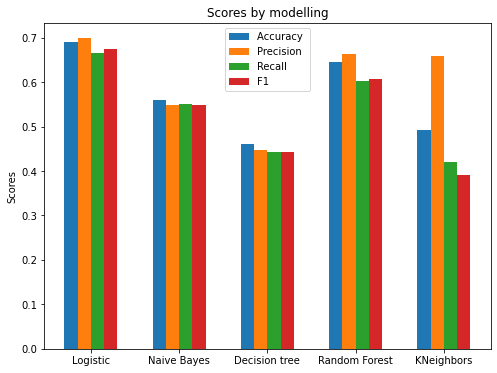

In [51]:
# plotting the graph
plt.figure(figsize=(8,6))
ind = np.arange(5) 
width = 0.15       
plt.bar(ind, accuracy_scores , width, label='Accuracy ')
plt.bar(ind + width, precision_scores, width, label='Precision')
plt.bar(ind + width*2, recall_scores, width, label= 'Recall')
plt.bar(ind + width *3, f1_scores, width, label= 'F1 ')

plt.ylabel('Scores')
plt.title('Scores by modelling')
plt.xticks( ind + width*3 / 2 ,('Logistic', 'Naive Bayes', 'Decision tree', 'Random Forest', 'KNeighbors'))
plt.legend(loc='best')
plt.show()

## Conclusion

The graph above suggests that the performace of Logistic Regression model is better than every other model on the  book summaries data for predicting genre of a book based on a summary where all scores (accuracy,precision,recall,f1) are approximately 0.7 . The performace of Random forest model on data is second best followed by Gaussian Naive Bayes and KNeighbors Classifier. Decision tree model performance using book summary in predicting genres of book is the least amongst the five models.
From classification reports for all models, we can say that model's predicting is good on Fantasy,Mystery,Novel and Science Fiction but comparatively less on Chidren's literature.Which means predicting genre of Chidren's literature is a less precise based on the book summary as compared to other book genres.

Note:
Since we have used default or estimated values for building the models and not performed cross validation process (for example- to find optimal n_neighbors in KNeighbors), there might be some inaccuracies in predictions.